# Experiementing with Maximum Likelihood Parameter Estimation (MLE)
Ball drop

In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.integrate import odeint

## Generate data for a ball drop

In [55]:
def calculate_force(g, m):
    #return g*m - cd*u**2
    return g*m

def calculate_acceleration(g):
    return calculate_force(g=g, m=1)

def ball_drop_air(states, t, g):
    
    # states:
    # [x,u]
        
    x = states[0]
    u = states[1]
    dxdt = u
    
    dudt = calculate_acceleration(g=g)
    
    d_states_dt = np.array([dxdt,dudt])
    
    return d_states_dt

In [94]:
def simulate(states_0, t, g):
    states = odeint(func = ball_drop_air,y0 = states_0,t = t,args=(g,))
    return states

In [95]:
states_0 = np.array([0,0])
t = np.linspace(0,10,100)
g=9.81
m = 1
cd = 0.01
states = simulate(states_0=states_0,t = t, g=g)

In [96]:
x = states[:,0]
dxdt = states[:,1]

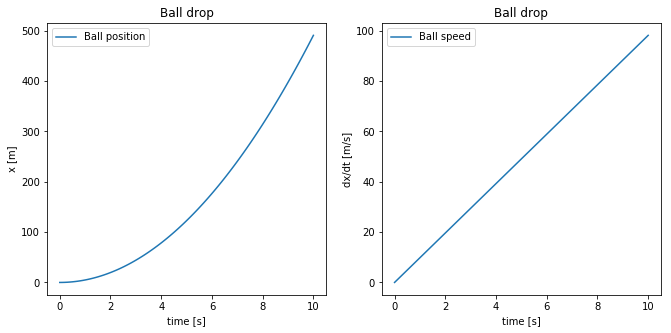

In [97]:
fig,axes = plt.subplots(ncols = 2)
fig.set_size_inches(11,5)
ax = axes[0]
ax.plot(t,x,label = 'Ball position')

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
a = ax.legend()

ax = axes[1]
ax.plot(t,dxdt,label = 'Ball speed')

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('dx/dt [m/s]')
a = ax.legend()

## Add measurement noice

In [117]:
ϵ = np.random.normal(loc = 0.0, scale = 4.0, size = len(x))
x_measure = x + ϵ

In [118]:
v_measure = np.gradient(x_measure,t)
a_measure = np.gradient(v_measure,t)

In [119]:
df = pd.DataFrame({'t':t, 'x':x_measure, 'v':v_measure, 'a':a_measure})

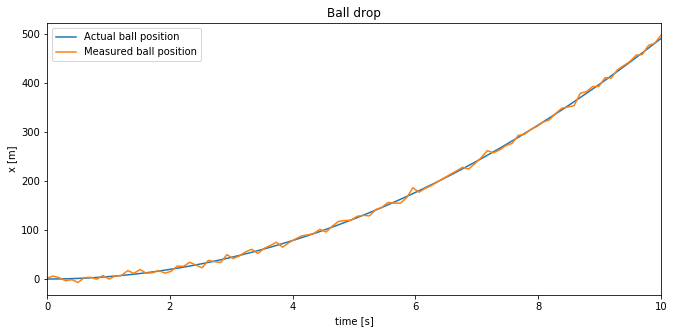

In [120]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)
ax.plot(t,x, label = 'Actual ball position')
df.plot(x='t', y='x', label = 'Measured ball position', ax=ax)
ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()

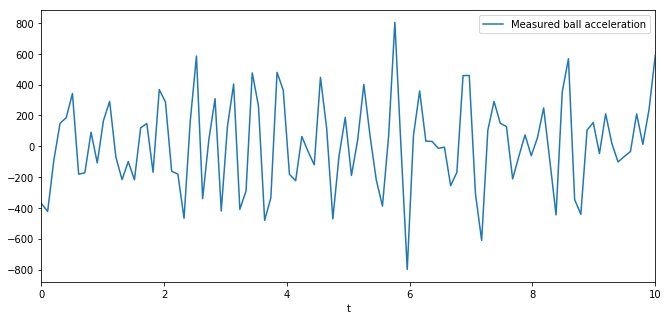

In [121]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)
df.plot(x='t', y='a', ax=ax, label='Measured ball acceleration')

## Maximum Likelihood 

### define likelihood function


In [122]:
def MLERegression(params):
    
    g, std = params[0], params[1] # inputs are guesses at our parameters
    
    t = None
    
    ahat = calculate_acceleration(g=g)
    
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(a_measure, loc=ahat, scale=std) )
    # return negative LL
    return(negLL)

In [123]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,10])
results = minimize(MLERegression, guess, method = 'Nelder-Mead', 
          options={'disp': True})

Optimization terminated successfully.
         Current function value: 710.565391
         Iterations: 66
         Function evaluations: 130


In [124]:
results

 final_simplex: (array([[ 13.24340504, 294.92333604],
       [ 13.24336015, 294.92326423],
       [ 13.24333799, 294.92339478]]), array([710.56539126, 710.56539126, 710.56539126]))
           fun: 710.5653912565398
       message: 'Optimization terminated successfully.'
          nfev: 130
           nit: 66
        status: 0
       success: True
             x: array([ 13.24340504, 294.92333604])

In [125]:
coefficients = results['x'][0:-1]
g_pred = coefficients[0]
g_pred

13.24340503605831

In [126]:
def MLERegression2(params):
    
    v_0, a_0, g, std = params[0], params[1], params[2], params[3] # inputs are guesses at our parameters
    
    states_0 = [v_0, a_0]
    states = simulate(states_0, t, g)
    xhat = states[:,0]
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(x_measure, loc=xhat, scale=std) )
    # return negative LL
    return(negLL)

In [127]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([0, 0, 5, 10])
results = minimize(MLERegression2, guess, method = 'Nelder-Mead', 
          options={'disp': True})

Optimization terminated successfully.
         Current function value: 289.072844
         Iterations: 115
         Function evaluations: 210


In [128]:
results

 final_simplex: (array([[-2.31376281e-03,  2.09220738e-03,  9.83216620e+00,
         4.35704131e+00],
       [-2.31377670e-03,  2.09220400e-03,  9.83216316e+00,
         4.35707826e+00],
       [-2.31377237e-03,  2.09221132e-03,  9.83216796e+00,
         4.35703054e+00],
       [-2.31374890e-03,  2.09223663e-03,  9.83216189e+00,
         4.35694790e+00],
       [-2.31372445e-03,  2.09220260e-03,  9.83215760e+00,
         4.35700053e+00]]), array([289.07284399, 289.072844  , 289.07284401, 289.07284402,
       289.07284402]))
           fun: 289.07284399460906
       message: 'Optimization terminated successfully.'
          nfev: 210
           nit: 115
        status: 0
       success: True
             x: array([-2.31376281e-03,  2.09220738e-03,  9.83216620e+00,  4.35704131e+00])

In [129]:
coefficients = results['x']

In [133]:
states_0_pred = coefficients[0:2]
g_pred = coefficients[2]
states_pred = simulate(states_0=states_0_pred,t = t, g=g_pred)
x_pred = states_pred[:,0]
v_pred = states_pred[:,1]


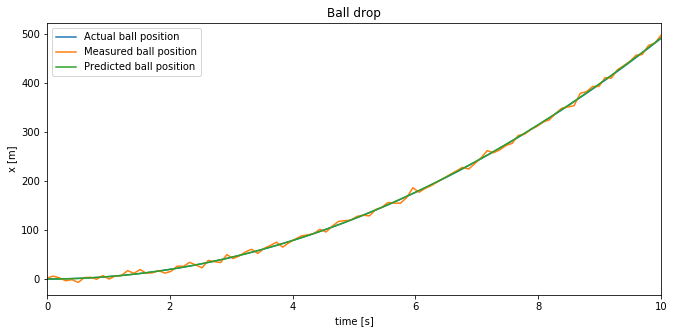

In [134]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)
ax.plot(t,x, label = 'Actual ball position')
df.plot(x='t', y='x', label = 'Measured ball position', ax=ax)
ax.plot(t,x_pred, label = 'Predicted ball position')
ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()